In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-model2/model_02.pkl
/kaggle/input/convnext-model01/convnext_model.pkl
/kaggle/input/new-dog/yorkshire-terrier-ga4fe655bb_1280.jpg
/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier/n02098105_1664.jpg
/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier/n02098105_2846.jpg
/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier/n02098105_3048.jpg
/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier/n02098105_1564.jpg
/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier/n02098105_2157.jpg
/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier/n02098105_838.jpg
/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier/n02098105_2138.jpg
/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier/n02098

**modif du 07/06/2023**

In [2]:
import fastai
print(fastai.__version__)

2.7.12


In [3]:
from fastai.vision.all import *

In [4]:
from fastcore.all import *
from fastai.vision.widgets import *

In [5]:
!pip install timm

In [6]:
import timm 

timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

# Build a vision learner model
## Import data

In [7]:
path2cropped = Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0')

In [8]:
path2cropped.ls()

(#20) [Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier'),Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/papillon'),Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/Scottish_deerhound'),Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/standard_schnauzer'),Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/malamute'),Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/EntleBucher'),Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/Shih-Tzu'),Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/Boston_bull'),Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/Sussex_spaniel'),Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/cocker_spaniel')...]

## Get filenames

In [9]:
dogs_fnames = get_image_files(path2cropped) #function that returns a list of all the image files in the path
len(dogs_fnames)

3549

In [10]:
dogs_fnames[0],dogs_fnames[6]

(Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier/n02098105_1664.jpg'),
 Path('/kaggle/input/compressed-data-b20-cropped/Data_sample_B20_n0/soft-coated_wheaten_terrier/n02098105_2138.jpg'))

In [11]:
# print(files[0].name)
# pat = r'^(.*)_\d+.jpg'
# pat
parent_label(dogs_fnames[0])

'soft-coated_wheaten_terrier'

## Create DataBlock

In [12]:
StanfordDogs = DataBlock(blocks=(ImageBlock, CategoryBlock), #ssame as before
                 get_items=get_image_files,  #get filenames from a path we specify later
                 splitter=RandomSplitter(), #random ssplit to have a train and a validation set
                 get_y=parent_label, #a pipeline to extract labels using regex
                 item_tfms=Resize(256, ResizeMethod.Pad, pad_mode='zeros'),#we need to resize all images at same size
                batch_tfms=aug_transforms())
#                  batch_tfms=aug_transforms()) #we want to apply image augmentation

**data size is 256 because 128 is not always enough to have all dog image in the photo**

In [13]:
dls_cropped20pets = StanfordDogs.dataloaders(path2cropped, bs=32)
# dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

In [14]:
dls_cropped20pets.bs

32

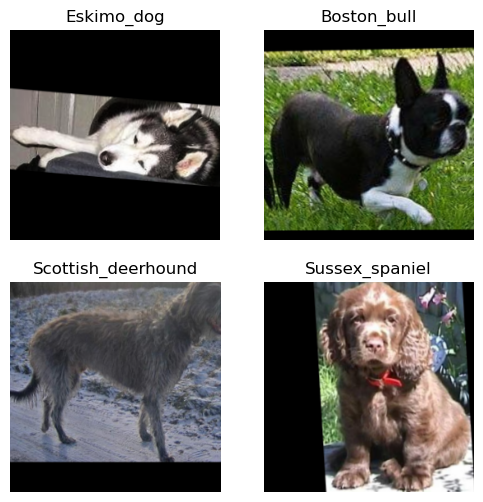

In [15]:
dls_cropped20pets.show_batch(max_n=4)

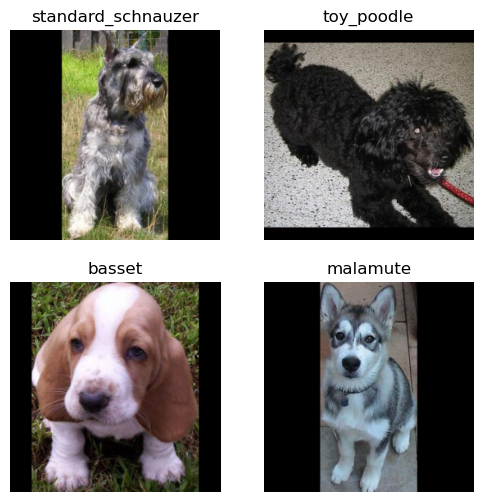

In [16]:
dls_cropped20pets.valid.show_batch(max_n=4)

stop

## Build basic learner

In [17]:
learn = vision_learner(dls_cropped20pets, resnet34, metrics=[error_rate, accuracy])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s] 


In [18]:
learn.summary()

Sequential (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

# Train vision learner
## Strategy_1: total fine-tuning using optimal learning rate

SuggestedLRs(valley=0.001737800776027143)

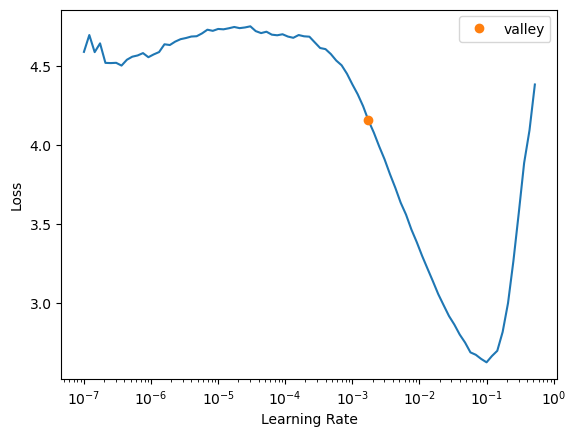

In [19]:
learn.lr_find()

In [20]:
learn.fine_tune(4, 5e-3)
# learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

**Can't really change fine_tune parameters because number of epochs and learning rates are correlated between head and body training**

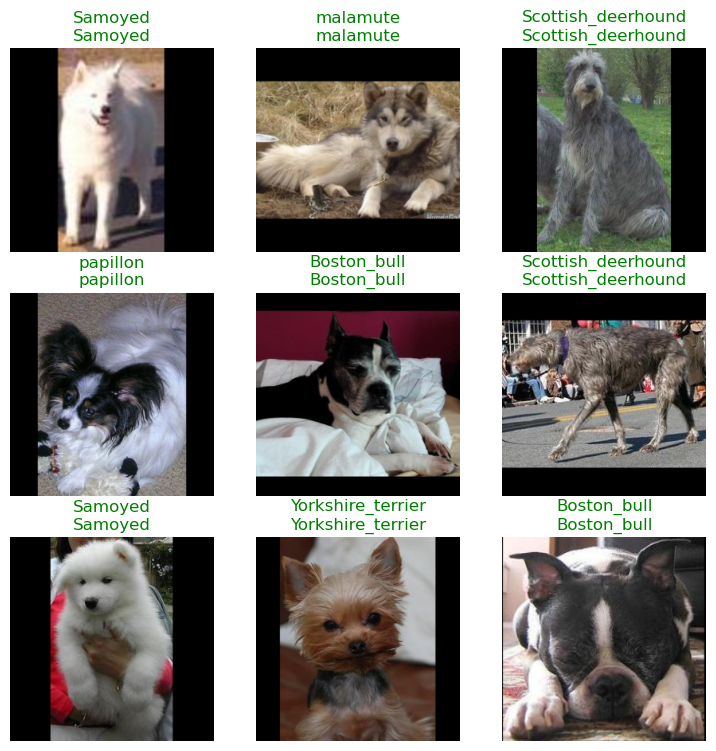

In [21]:
learn.show_results()

In [22]:
# SAVE MODEL
learn.export('/kaggle/working/model_02.pkl')

## Strategy_2: training using fit_one_cycle

In [23]:
learn_2 = vision_learner(dls_cropped20pets, resnet34, metrics=[error_rate, accuracy])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.001737800776027143)

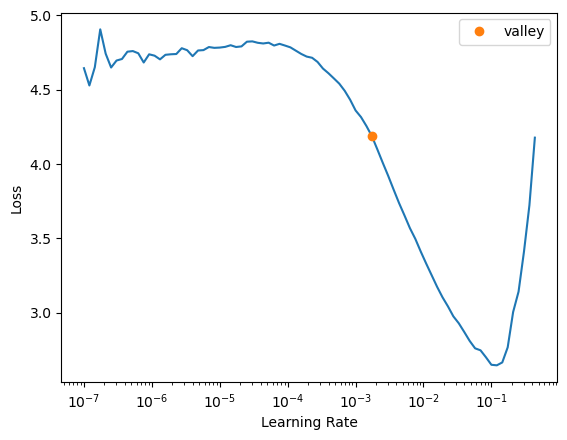

In [24]:
# MAYBE NEEDS TO BE DONE EARLIER THAN fit_one_cycle() call
learn_2.lr_find()

In [25]:
learn_2.summary()

Sequential (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [26]:
learn_2.freeze_to(-1) ## equivalent to freeze() in this case
learn_2.summary()

Sequential (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [27]:
#----- modifs du 19-07-2023------#
# Set the number of epochs for the head
num_epochs_head = 5

# Freeze the body of the model and train the head
learn_2.freeze()
learn_2.fit_one_cycle(num_epochs_head)

In [28]:
# Set the number of epochs for the whole model
num_epochs_whole = 10

# Unfreeze the body of the model and train the whole model
learn_2.unfreeze()
learn_2.fit_one_cycle(num_epochs_whole)

**fit_one_cycle() a besoin de plus de temps pour converger que fine_tune(), une fois le bon lr defini**

fine_tune() et fit_one_cycle() ne peuvent pas se suivre, startegies de learning rate differentes!

SuggestedLRs(valley=2.0892961401841603e-05)

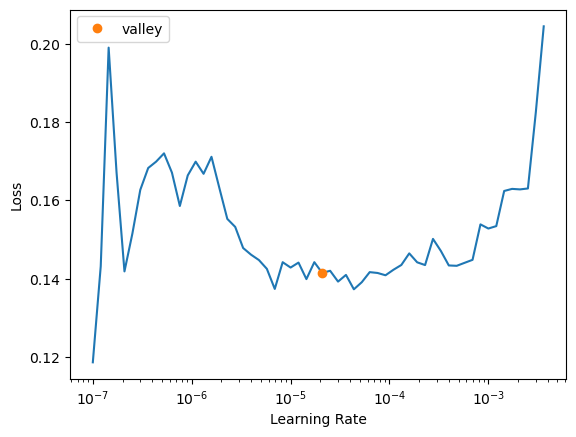

In [29]:
learn_2.recorder.lr_find()
#first iteration gave ~4e-3

In [30]:
learn_2.fit_one_cycle(1, slice(1e-2/(2.6**4),4e-3))
# learn_2.recorder.plt_lr_find()

**il serait plus judicieux de passer par une recherche manuelle du learning rate avec des pretrained (la fonciton fit_one_cycle implemente le fit, pas le fine-tune..?**

## Get the categories of a model 
modif apres version 6 - 12/07/2023

In [31]:
categories = learn.dls.vocab
# FUNCTION TO RETURN A DICTIONARY OF PROBABILITIES
def classify_image(img):
    pred, indx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))

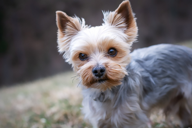

In [32]:
# Load and preprocess the image
image = PILImage.create('/kaggle/input/new-dog/yorkshire-terrier-ga4fe655bb_1280.jpg')
image.thumbnail((192, 192))
image

In [33]:
%time learn.predict(image)
pred_class, pred_idx, outputs = learn.predict(image)
# Print the predicted class
print(pred_class)

CPU times: user 36.6 ms, sys: 7.11 ms, total: 43.7 ms
Wall time: 67.4 ms


Yorkshire_terrier


In [34]:
classify_image(image)

{'Australian_terrier': 0.0011561807477846742,
 'Boston_bull': 1.094897825737462e-07,
 'EntleBucher': 7.071955820947551e-08,
 'Eskimo_dog': 2.3688006933753059e-07,
 'Rhodesian_ridgeback': 6.375783812018199e-08,
 'Samoyed': 2.901033857583002e-09,
 'Scotch_terrier': 1.4360134059643315e-07,
 'Scottish_deerhound': 1.2638995627867189e-08,
 'Shih-Tzu': 1.042820713337278e-05,
 'Sussex_spaniel': 3.717805796554785e-08,
 'Yorkshire_terrier': 0.9988245368003845,
 'basset': 4.7906866029734374e-08,
 'cocker_spaniel': 4.84034368142261e-10,
 'dingo': 4.429568711827869e-09,
 'malamute': 1.1586895887205628e-08,
 'miniature_pinscher': 1.1204281236132374e-06,
 'papillon': 1.1789679632556727e-07,
 'soft-coated_wheaten_terrier': 2.8895296964037698e-06,
 'standard_schnauzer': 3.7996283026586752e-06,
 'toy_poodle': 1.428560807426038e-07}

**Model will only be returning the prediction with the maximal class probability since this is a multiclass problem**

In [35]:
m = learn.model
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [36]:
# m.get_submodule('0.4.0')
# l=m.get_submodule('0.4.0')
# list(l.parameters())

## Metrics

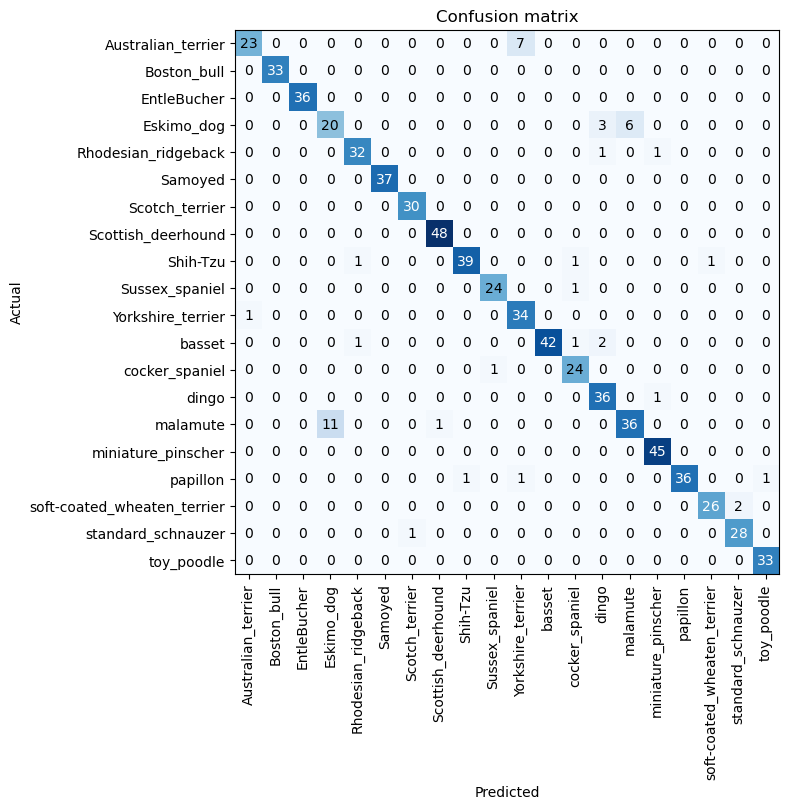

In [79]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))
plt.savefig("Confusion_matrix_basic_learner.png")

Highest wrong predictions seem to be among breeds of same class (spaniel(4), terrier(6), eskimo dog vs malamutes)
It is not symmetricla though. Confusing eskimo dog with malamutes happens more than confusing malamutes with Eskimo.. 

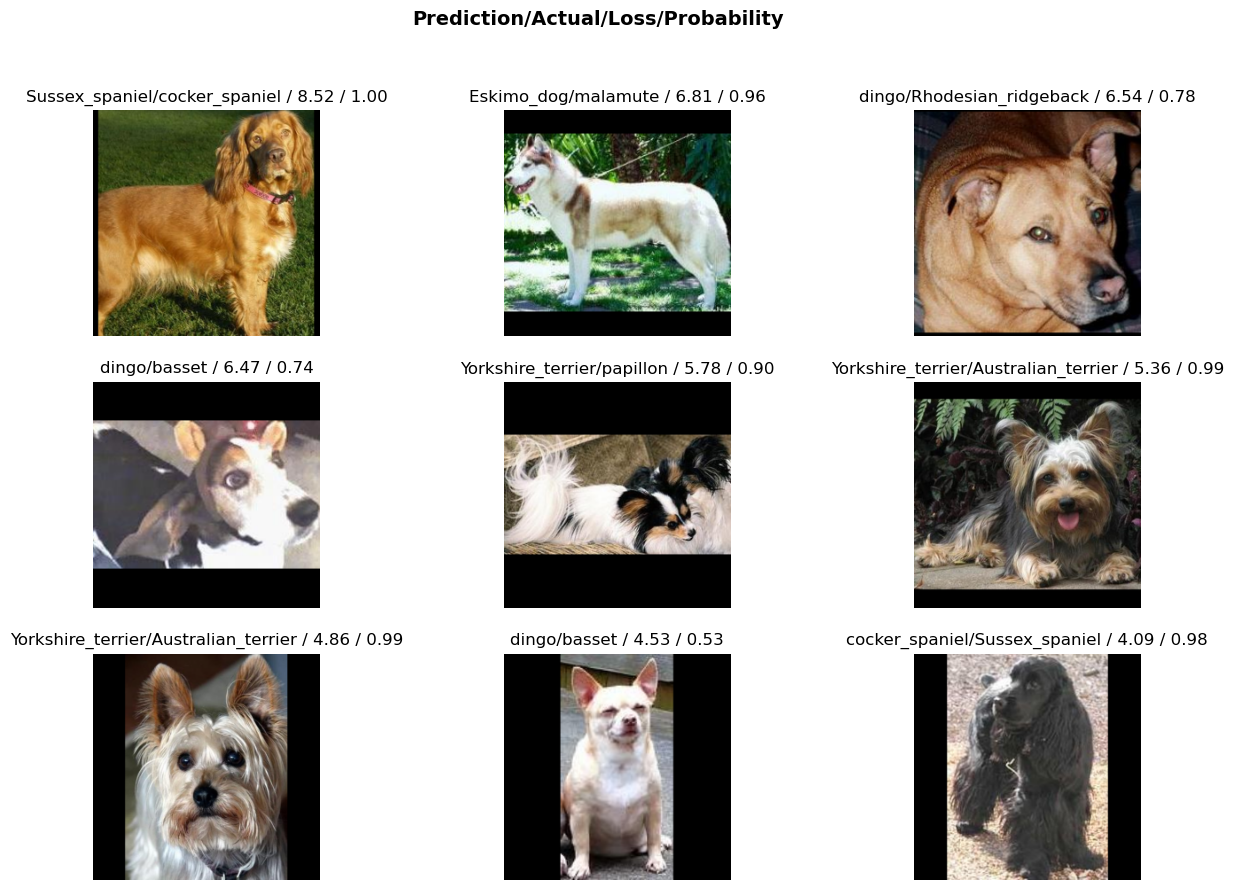

In [38]:
interp.plot_top_losses(9, figsize=(15,10))

the loss is by default the function being optimized. So the loss would be worst where the model predicted wrongly and was very confident in its error, or when it is right but with very little confidence

## Clean highly confusing pictures

In [39]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [40]:
dls_cropped20pets.bs

32

In [41]:
import torch
torch.cuda.empty_cache()

Sometimes, we use deep learning algorithms to correct the labels that were attributed instead of guessing new ones

------------ section 2-------------

# Build a timm learner

## Loop on models to compare performance 

In [42]:
# Define the models to compare
models = [(vision_learner(dls_cropped20pets, x, metrics=[error_rate, accuracy]).to_fp16()) for x in ['convnextv2_tiny' ,'inception_v4', 'efficientnet_b0']]

# Lists to store accuracies and training times
timm_accuracies = []
training_times = []

In [43]:
# Loop over the models
for i, model in enumerate(models):
    # Start the timer
    start_time = time.time()
    
    # Train the model with all layers unfrozen for 4 epochs
    model.fine_tune(2)
    
    # Calculate the training time
    elapsed_time = time.time() - start_time
    training_times.append(elapsed_time)
    
    # Get the accuracy on the validation dataset
    model_accuracy = model.validate()[2] #would have been 1 had we asked fror accuracy only in metrics!
    timm_accuracies.append(model_accuracy)
    
    # Print the results
    print(f"Model {i+1}: Accuracy - {model_accuracy:.4f}, Training Time - {elapsed_time:.2f} seconds")

Model 1: Accuracy - 0.9676, Training Time - 127.21 seconds


Model 2: Accuracy - 0.9379, Training Time - 138.46 seconds


Model 3: Accuracy - 0.8886, Training Time - 94.51 seconds


Obsserve how convnext seems to have, for a fixed accuracy, optimized loss during second pass

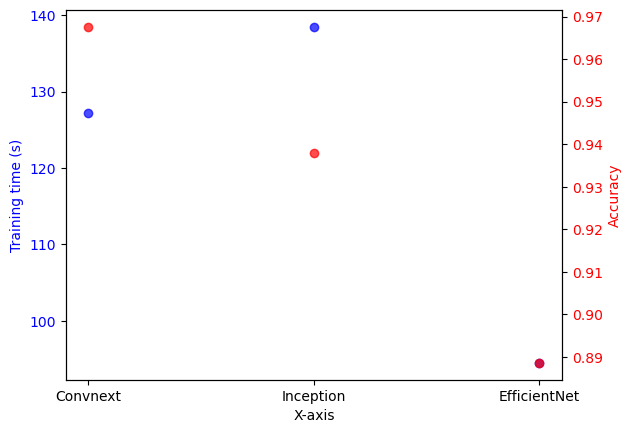

In [44]:
# Create Plot
labels = ['Convnext', 'Inception', 'EfficientNet']
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('X-axis') 
ax1.set_ylabel('Training time (s)', color = 'blue') 
ax1.scatter(labels, training_times, alpha=0.7, color='b')
ax1.tick_params(axis ='y', labelcolor = 'blue') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Accuracy', color = 'red') 
ax2.scatter(labels,timm_accuracies, alpha=0.7, color='r')
ax2.tick_params(axis ='y', labelcolor = 'red') 
 
# Show plot

plt.show()
# # Plot the accuracies and training times
# labels = ['Convnext', 'Inception', 'EfficientNet']
# plt.figure(figsize=(10, 6))
# plt.scatter(labels, timm_accuracies, alpha=0.7, color='b')
# plt.ylabel('Accuracy')
# plt.title('Comparison of Model Accuracies')
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.scatter(labels, training_times, alpha=0.7, color='r')
# plt.ylabel('Training Time (seconds)')
# plt.title('Comparison of Model Training Times')
# plt.show()


## Choose a timm learner based on previous scores

In [45]:
# timm.list_models ('convnext*')
learn_timm_convnext = vision_learner(dls_cropped20pets, 'convnextv2_tiny', metrics=[error_rate, accuracy]).to_fp16()

In [46]:
learn_timm_convnext.summary()

Sequential (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 96 x 64 x 64   
Conv2d                                    4704       False     
LayerNorm2d                               192        True      
Identity                                                       
Conv2d                                    4800       False     
LayerNorm                                 192        True      
____________________________________________________________________________
                     32 x 64 x 64 x 384  
Linear                                    37248      False     
GELU                                                           
Dropout                                                        
GlobalResponseNorm                        768        False     
____________________________________________________________________________
                     32 x 64 x 64 x 96   
Linear                             

## Looking for optimal learning rate

SuggestedLRs(valley=0.0012022644514217973)

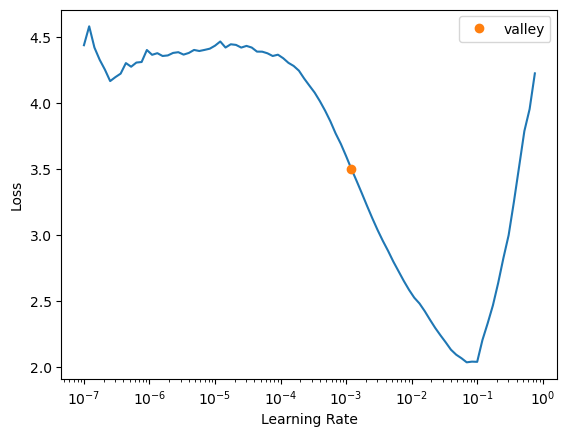

In [47]:
# Find the optimal learning rate
learn_timm_convnext.recorder.lr_find()

Recorder is a Callback that registers statistics (lr, loss and metrics) during training.

By default, metrics are computed on the validation set only,

## Training the head only

In [48]:
# Freeze all layers except the last one
learn_timm_convnext.freeze_to(-1) # probably redundant
# only way to train head only is to use fit_one_cycle
learn_timm_convnext.fit_one_cycle(1)

**Excellent accuracy is achieved. Can we retrieve optimal learning_rate and fine-tune all body with it for an increased accuracy?**

In [49]:
# Unfreeze the entire model
learn_timm_convnext.unfreeze() #redundant with fine_tune() but used here to visualize model ssummary
learn_timm_convnext.summary()

Sequential (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 96 x 64 x 64   
Conv2d                                    4704       True      
LayerNorm2d                               192        True      
Identity                                                       
Conv2d                                    4800       True      
LayerNorm                                 192        True      
____________________________________________________________________________
                     32 x 64 x 64 x 384  
Linear                                    37248      True      
GELU                                                           
Dropout                                                        
GlobalResponseNorm                        768        True      
____________________________________________________________________________
                     32 x 64 x 64 x 96   
Linear                             

SuggestedLRs(valley=2.75422871709452e-06)

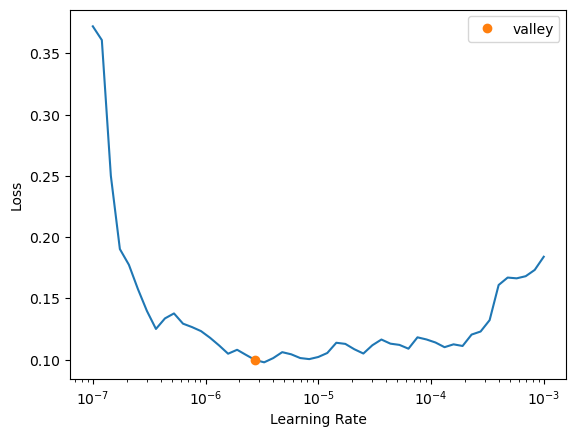

In [50]:
# Find the optimal learning rate
learn_timm_convnext.recorder.lr_find() 
# CANNOt DO THIS WITH ALL LAYERS FROZEN EXCEPT HEAD?
# Plot the learning rate finder plot
# learn_timm_convnext.recorder.plot_lr_find()
#!!ATTENTION1 CANNOT CALL RECORDER BEFORE FINDER PLOT
# Plot the learning rate finder plot

## Tune all weights

In [51]:
learn_timm_convnext.fine_tune(4, 5e-4) #lr modified from 5e-3 to 5e-4

# 4 times on the head, can modify the number of epochs on the weights as well >. CHECKED

**By tuning all weights, we get an optimal accuracy and val_loss as by tuning the head itself (reached in 4 epochs), and almost 3 times smaller train_loss than resnet34**

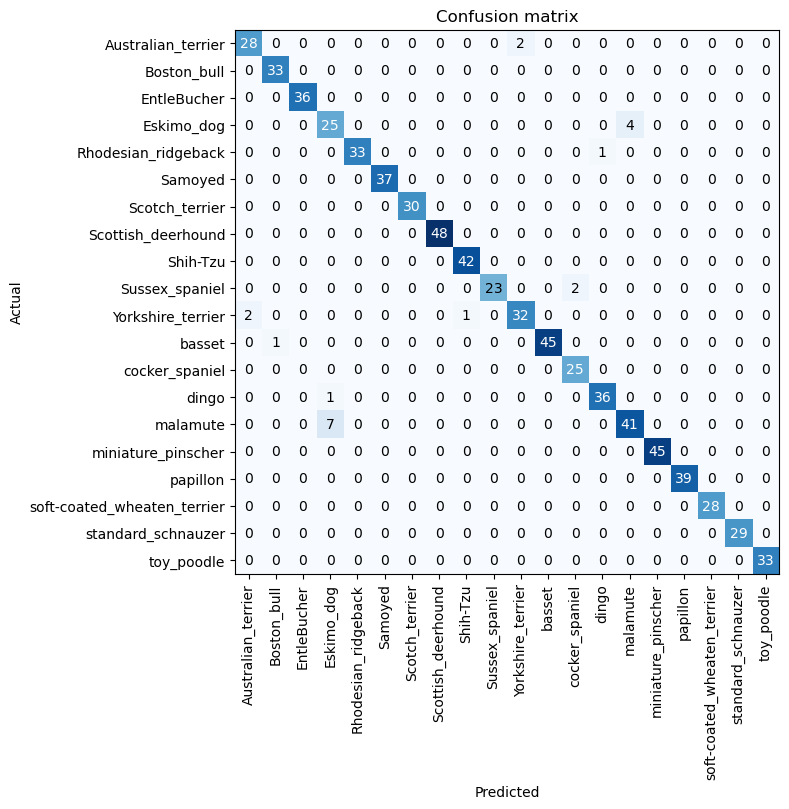

In [68]:
interp_2 = ClassificationInterpretation.from_learner(learn_timm_convnext)
interp_2.plot_confusion_matrix(figsize=(9,8))
plt.savefig("image.png")

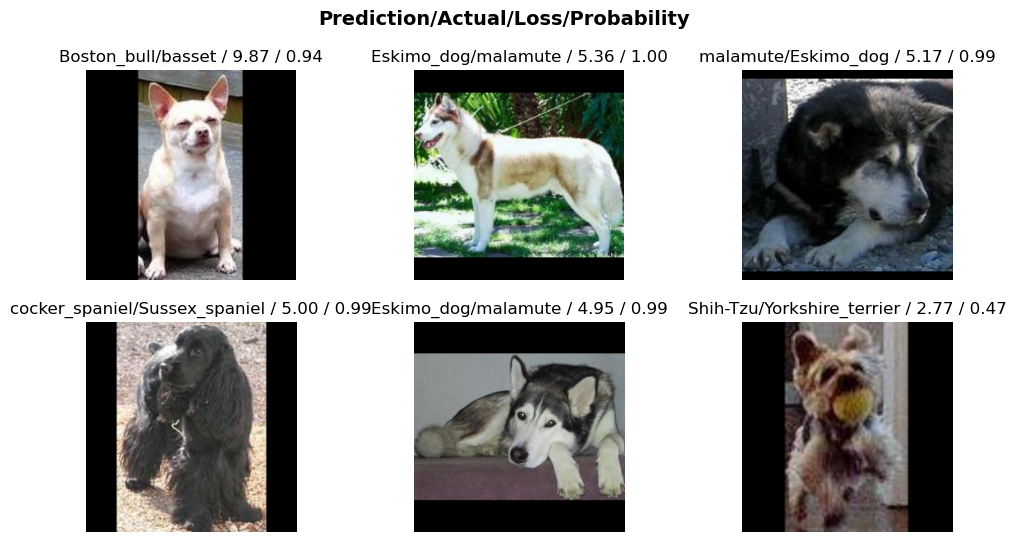

In [76]:
interp_2.plot_top_losses(6, figsize=(12,6))
plt.savefig("top_losses_convnext.png")

## Predict

In [1]:
# Load and preprocess the image
image = PILImage.create('/kaggle/input/new-dog/yorkshire-terrier-ga4fe655bb_1280.jpg')
image.thumbnail((192, 192))
image

NameError: name 'PILImage' is not defined

In [ ]:
%time learn_timm_convnext.predict(image)
pred_class, pred_idx, outputs = learn_timm_convnext.predict(image)
# Print the predicted class
print(pred_class)

In [55]:
# SAVE/LOAD MODEL
learn_timm_convnext.export('convnext_compared_model.pkl')

## Extract features from the first convolution layer

In [56]:
learn_timm_convnext.model[0]
# equivalent to
learn_timm_convnext.get_submodule('0')


TimmBody(
  (model): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
    

In [57]:
hook_layer = learn_timm_convnext.model[0]
# Function to store the extracted features
def hook_fn(module, input, output):
    learn_timm_convnext.features = output

# Register the hook with the first convolution layer
hook_handle = hook_layer.register_forward_hook(hook_fn)

# Get a sample image from the dataloader
xb, _ = learn_timm_convnext.dls.one_batch()
# Pass the sample image through the model to capture the features
with torch.no_grad():
    learn_timm_convnext.model.eval()
    learn_timm_convnext.model(xb.cuda())
    
# Remove the hook after capturing the features
hook_handle.remove()
# Visualize the extracted features
features = learn_timm_convnext.features[0].cpu()  # The first image's features
num_features = features.shape[0]

In [77]:
hook_layer = learn_timm_convnext.model[0]
# Function to store the extracted features
def hook_fn(module, input, output):
    learn_timm_convnext.features = output

# Register the hook with the first convolution layer
hook_handle = hook_layer.register_forward_hook(hook_fn)

# Get a sample image from the dataloader
xb, _ = learn_timm_convnext.dls.one_batch()
# Pass the sample image through the model to capture the features
with torch.no_grad():
    learn_timm_convnext.model.eval()
    learn_timm_convnext.model(xb.cuda())
    
# Remove the hook after capturing the features
hook_handle.remove()
# Visualize the extracted features
features = learn_timm_convnext.features[0].cpu()  # The first image's features
num_features = features.shape[0]
num_features

768

/tmp/ipykernel_29/1017166071.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


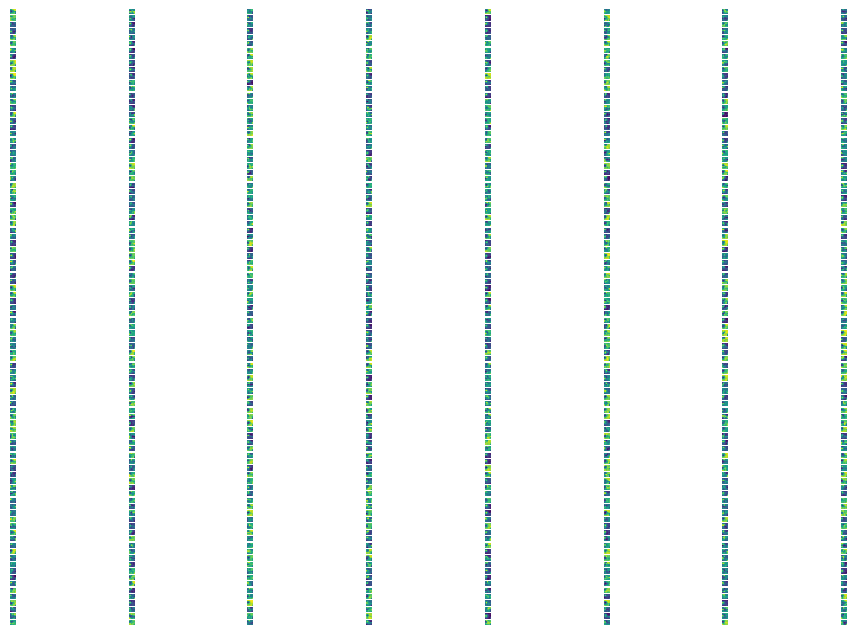

In [78]:

n_cols = 8  # Number of columns in the grid

plt.figure(figsize=(12, 8))
for i in range(num_features):
    plt.subplot(num_features // n_cols, n_cols, i + 1)
    plt.imshow(features[i], cmap='viridis')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [58]:
# Features from second convolution layer
learn_timm_convnext.model[0].model.stages[0].blocks[1]

ConvNeXtBlock(
  (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
  (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
  (mlp): GlobalResponseNormMlp(
    (fc1): Linear(in_features=96, out_features=384, bias=True)
    (act): GELU()
    (drop1): Dropout(p=0.0, inplace=False)
    (grn): GlobalResponseNorm()
    (fc2): Linear(in_features=384, out_features=96, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (shortcut): Identity()
  (drop_path): Identity()
)

In [59]:
# Define the hook function to capture the activations
activations = []
def hook_fn(module, input, output):
    activations.append(output)
# Register the hook to the second convolutional layer (index 2)
second_conv_layer = learn_timm_convnext.model[0].model.stages[0].blocks[1]
hook = second_conv_layer.register_forward_hook(hook_fn)

In [60]:
# Make a prediction to activate the hook
learn_timm_convnext.predict(dls_cropped20pets.train_ds[0][0])

# Remove the hook to avoid affecting future computations
hook.remove()

# Visualize the extracted features for a sample image
sample_activations = activations[0][0].cpu()
n_channels = sample_activations.shape[0]

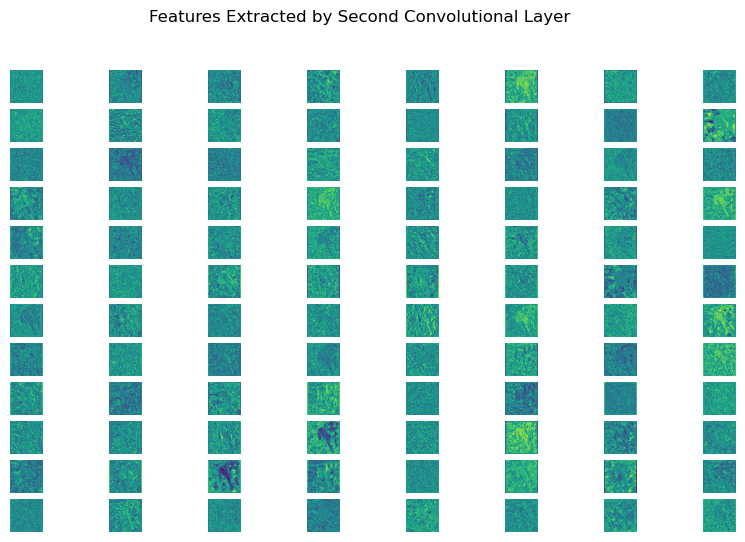

In [69]:
plt.figure(figsize=(10, 6))

for i in range(n_channels):
    plt.subplot(12, 8, i + 1)
    plt.imshow(sample_activations[i], cmap='viridis')
    plt.axis('off')

plt.suptitle('Features Extracted by Second Convolutional Layer')
plt.show()

# Convert TF model to pytorch

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# from sklearn.metrics import accuracy_score
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score, roc_curve

In [61]:
# # Define your data paths and transforms
# path = "path/to/dataset"
# train_tfms = transforms.Compose([...])  # Add your data transforms here
# valid_tfms = transforms.Compose([...])  # Add your data transforms here

# # Load your data and create DataLoader
# # Assuming you have a dataset and DataLoader for your data
# train_loader = ...
# valid_loader = ...

# # Define the model (ConvNeXt in this case)
# model_name = 'convnext'
# num_classes = 20  # Number of dog breeds as classes
# model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

# # Fine-tune the head of the model
# for param in model.parameters():
#     param.requires_grad = False

# in_features = model.head.fc.in_features
# model.head.fc = nn.Linear(in_features, num_classes)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Move the model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # Training the head of the model
# num_epochs_head = 5

# train_losses = []
# valid_losses = []
# accuracies = []

# for epoch in range(num_epochs_head):
#     model.train()
#     train_loss = 0.0

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() * inputs.size(0)

#     train_loss /= len(train_loader.dataset)
#     train_losses.append(train_loss)

#     # Evaluation on the validation set
#     model.eval()
#     valid_loss = 0.0
#     preds = []
#     true_labels = []

#     with torch.no_grad():
#         for inputs, labels in valid_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             valid_loss += loss.item() * inputs.size(0)

#             _, predicted = torch.max(outputs, 1)
#             preds.extend(predicted.cpu().numpy())
#             true_labels.extend(labels.cpu().numpy())

#     valid_loss /= len(valid_loader.dataset)
#     valid_losses.append(valid_loss)

#     accuracy = accuracy_score(true_labels, preds)
#     accuracies.append(accuracy)

#     print(f"Epoch {epoch+1}/{num_epochs_head}: "
#           f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}")

# # Plot learning rate, accuracy evolution, and the second convolutional layer features
# # The code for these visualizations goes here...

# # Now, unfreeze and train all weights
# for param in model.parameters():
#     param.requires_grad = True

# # Reset optimizer with a lower learning rate for fine-tuning
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# # Continue training the model for additional epochs
# num_epochs_whole = 10

# for epoch in range(num_epochs_head, num_epochs_head + num_epochs_whole):
#     # The training and validation loop is similar to the above one for num_epochs_head

# # Plot learning rate, accuracy evolution, and the second convolutional layer features
# # The code for these visualizations goes here...


SyntaxError: incomplete input (295880124.py, line 108)

In [ ]:
# # IMPLEMENTING A NEW ACCURACY METHOD FOR AUC COMPUTATION
# # --- fast.ai.docs ---- #
# learn = synth_learner() #call the learner
# tst = AvgMetric(lambda x,y: (x-y).abs().mean())
# t,u = torch.randn(100),torch.randn(100)
# tst.reset()
# for i in range(0,100,25): 
# #     learn.pred,learn.yb = t[i:i+25],(u[i:i+25],)
#     preds, targets = learn_inception.get_preds(dl=dls_cropped20pets.valid)
#     tst.accumulate(learn)
# test_close(tst.value, (t-u).abs().mean())

# # -----CHATGPT--- #

# from sklearn.metrics import roc_auc_score, roc_curve

# # Get the predictions and true labels
# preds, targets = learn_inception.get_preds()
# print(preds)


# # Compute the ROC-AUC score
# auc_score = roc_auc_score(targets, preds[:, 1], multi_class='ovr')

# # Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for the ROC curve
# fpr, tpr, _ = roc_curve(targets, preds[:, 1])

# # Plot the ROC curve
# plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
# plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend()
# plt.show()

In [ ]:
# # Get the predictions and true labels for the validation set
# preds, targets = learn_timm_convnext.get_preds(dl=dls_cropped20pets.valid)
#  RocAuc(axis=-1, average='macro', sample_weight=None, max_fpr=None,
#          multi_class='ovr')
# # Compute the AUC score for each class
# auc_scores = roc_auc_metric(targets, preds, multi_class='ovr')

# # Plot the AUC curve
# plt.figure(figsize=(10, 6))
# for i in range(len(dls_cropped20pets.valid.vocab)):
#     fpr, tpr, _ = roc_curve(targets[i], preds[:, i])
#     plt.plot(fpr, tpr, label=f'Class {dls_cropped20pets.valid.vocab[i]} (AUC = {auc_scores[i]:.2f})')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Multi-class Classification')
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
# TEST CELL
# preds[:,1]
# targets[3]